
# <h1><center>Brittle Star Environment Tutorial</center></h1>

This notebook provides an introductory tutorial to the [Brittle Star environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star), which is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb).

Preferably use a Jupyter runtime with GPU acceleration enabled.  

## The Bio-inspired Robotics Benchmark (BRB)
The Bio-Inspired Robotics Benchmark represents a significant stride in the convergence of robotics and experimental biology, offering a unique platform that leverages the MuJoCo physics simulator to create a collection of bio-inspired robotics simulation environments. This initiative is more than just a technical tool; it serves as a crucible for cross-disciplinary dialogue and innovation, uniting two fields that, while distinct, share a common goal of understanding and emulating complex biological systems.

In the realm of robotics, this benchmark addresses a pivotal challenge: the design and control of bio-inspired robots. These robots, inspired by the intricacies of biological organisms, present novel hurdles that contemporary optimization methodologies struggle to surmount. By providing a benchmark specifically tailored to these challenges, the initiative not only facilitates the validation of existing methodologies but also catalyzes the development of new approaches. This is crucial for advancing the field, as it pushes the boundaries of what we can achieve in robotic design and control, drawing inspiration from the most sophisticated systems found in nature.

On the biological front, the application of robotics serves as a powerful comparative method. It offers a more controlled environment for conducting comparative studies, essential for dissecting complex behaviors, ecological interactions, and the evolutionary histories of organisms. This perspective is invaluable, as it transcends traditional observational methods, allowing for more controlled analyses.

Overall, the Bio-Inspired Robotics Benchmark is a testament to the symbiotic potential of robotics and biology. It not only advances our technical capabilities in creating machines that mimic life but also deepens our understanding of the biological phenomena that inspire these creations. This benchmark is a stepping stone towards a future where the interplay between robotics and biology yields innovations that are as profound as they are transformative. 


The Bio-Inspired Robotics Benchmark distinguishes itself with its capability to effortlessly simulate various morphological variations of bio-inspired robots. This flexibility is largely enabled by the use of the [Framework for Parameterized Robot Specifications (FPRS)](https://github.com/Co-Evolve/fprs), a framework that centralizes the adaptable definition of a robot's morphology. In FPRS, a 'Specification' acts as a comprehensive bundle, encapsulating all the modifiable parameters that define the robot's form and structure. This approach to morphology parameterization not only simplifies the modification process but also enhances the reproducibility and comparability of different morphological setups within the BRB.

The implementation of environments within the BRB adheres to framework defined in the [mujoco-utils package](https://github.com/Co-Evolve/mujoco-utils/tree/new-framework). This framework defines an environment as a combination of a parameterized morphology, as defined by FPRS, and a configurable arena. Both the morphology and the arena in this context are essentially generators for MJCF (MuJoCo XML) files, allowing for dynamic and customizable environment creation. This design philosophy ensures that each environment within the BRB is both flexible and specific to the needs of the experiment at hand.

In terms of simulation capabilities, the BRB offers environments in both native MuJoCo and MuJoCo XLA (MJX) formats. This dual availability caters to diverse computational needs and preferences, ensuring that researchers can select the simulation environment that best suits their specific requirements, whether it's the high-fidelity physics of native MuJoCo or the accelerated computation offered by MuJoCo XLA.

In summary, the BRB's unique approach to morphology parameterization through FPRS, adherence to the mujoco-utils framework for environment implementation, and availability in both MuJoCo and MJX formats, collectively contribute to its status as a versatile and powerful tool for bio-inspired robotics research. This tool not only facilitates a deeper exploration of robotic morphologies but also bridges the gap between theoretical research and practical application in the field of bio-inspired robotics.

### Preliminary checks

Before continuing, check if the following points towards your (conda) environment with JAX and the BRB installed. If not, follow these [steps](https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084).

In [1]:
import sys
print(sys.executable)

/user/gent/432/vsc43242/.conda/envs/example-env/bin/python


Install the BRB package and its dependencies.

In [2]:
import logging
try:
    import brb
except ImportError:
    logging.error("Please install the BRB package first to the kernel's underlying environment via 'python -m pip install git+https://github.com/Co-Evolve/brb@new-framework'")

Check if the underlying MuJoCo installation was successful. This will also check if Jax is able to find the GPU. If not, a warning will be printed.

In [3]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    xla_flags = os.environ.get('XLA_FLAGS', '')
    xla_flags += ' --xla_gpu_triton_gemm_any=True'
    os.environ['XLA_FLAGS'] = xla_flags

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Fri Feb  2 13:50:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:C1:00.0 Off |                    0 |
| N/A   32C    P0              61W / 500W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Some packages and utility functions for visualization.

In [4]:
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from mujoco_utils.mjcf_utils import MJCFRootComponent
import numpy as np
import jax
import jax.numpy as jnp
from typing import Union, List

# Graphics and plotting.
ffmpeg_v = !command -v ffmpeg
assert "command not found" not in ffmpeg_v, f"Please install FFmpeg for visualizations."
!{sys.executable} -m pip install -q mediapy
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
jnp.set_printoptions(precision=3, suppress=True, linewidth=100)


def visualize_mjcf(
        mjcf: MJCFRootComponent
        ) -> None:
    model = mujoco.MjModel.from_xml_string(mjcf.get_mjcf_str())
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None]
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379).")
    return media.show_video(images=filtered_images)

## The Brittle Star Environment
> “The whole of the brittle stars are curious and restless beings. They can never remain in the same attitude for the tenth part of a second, but are constantly twisting their long arms, as if they were indeed the serpents with which Medusa’s head was surrounded.” -- J. G. Wood, 1898

The Brittle Star Robot environment within the Bio-Inspired Robotics Benchmark (BRB) presents an intriguing case study, embodying the intersection of natural biological systems and robotic engineering. To introduce this environment, it's essential to first understand the biological entity that inspired it: the brittle star.

![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_stars_species.jpg?raw=true)
(Image src: https://doi.org/10.1016/j.jsb.2020.107481)

### The Brittle Star
Brittle stars, belonging to the class Ophiuroidea, are remarkable echinoderms distinguished by their distinctively slender arms and central disk. They inhabit various marine environments, showcasing a fascinating array of behaviors and adaptations that have captivated biologists for decades. One of the most striking features of brittle stars is their locomotion. Unlike their close relatives, the starfish, brittle stars move with a unique, elegant undulating motion of their arms. This locomotion is not only efficient but also highly adaptable, allowing them to navigate complex underwater terrains with agility and precision.

In addition to locomotion, brittle stars use their arms to hold onto substrates, coiling their flexible arms tightly around structurally complex objects such as kelp, sponges, or corals, with spines located along the arms aiding in the anchoring process.

From an evolutionary standpoint, brittle stars represent a significant lineage, offering insights into the adaptability and resilience of marine life. Their ability to regenerate lost limbs and their sensory capabilities, which include responding to light without distinct eyes, are just a few examples of their remarkable biological traits. These characteristics make them an excellent subject for bio-inspired robotics, as they provide a template for designing robots that are both flexible and resilient, capable of navigating and adapting to diverse environments.

#### Morphology
![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_stars_arm_anatomy.jpg?raw=true)
(Image src: https://doi.org/10.1016/j.jsb.2020.107481) 

At the core of a brittle star's anatomy is the central disk, which varies in size from as small as 3mm to as large as 50mm. This disk is not just a structural component but also serves as a crucial hub for the organism's nervous system and, in some species, reproductive organs. 

Brittle stars possess five arms that are symmetrically arranged in a pentaradial fashion around the central disk. This pentaradial symmetry is a hallmark of echinoderms and is crucial for the brittle star's locomotion and interaction with its environment. These arms typically span about two to twenty times the diameter of the central disk. In terms of mobility, the arms of brittle stars are capable of both in-plane and out-of-plane bending.

Structurally, each arm consists of a chain of segments, each one consisting out of a vertebra and 4 muscle groups and completely enclosed by plates. This skeletal structure provides both support and flexibility, enabling the arms to move fluidly while maintaining structural integrity.

![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_stars_muscles.jpg?raw=true)
(Image src: https://doi.org/10.3389/fnbot.2019.00104)

Lastly, the arms of brittle stars are adorned with soft spines. These spines play a crucial role in anchoring and interacting with the environment. They provide stability and traction on various surfaces, aiding in locomotion and foraging activities.

For an interesting read w.r.t. brittle star morphology: [The structural origins of brittle star arm kinematics: An integrated tomographic, additive manufacturing, and parametric modeling-based approach](https://www.sciencedirect.com/science/article/pii/S1047847720300447) 

#### Nervous system
![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_stars_nervous_system.jpg?raw=true)
(Image src: http://dx.doi.org/10.3389/fnbot.2019.00066)

The nervous system of the brittle star is a fascinating aspect of its biology, characterized by its decentralized nature. This decentralized nervous system is quite different from the central nervous systems found in vertebrates and even some invertebrates. In brittle stars, the nervous system is primarily composed of a nerve ring that encircles the central disk, from which branches extend into each arm.

The nerve ring acts as a central hub, integrating sensory inputs and coordinating the movements of the arms. Unlike centralized nervous systems where a brain or a similar central organ exerts control, the nerve ring in brittle stars does not function as a central command center. Instead, it serves more as a conduit or a relay station, facilitating communication across the organism's body.

From this nerve ring, nerve branches run along each arm, allowing for localized control and sensory perception within each limb. This structure is crucial for the brittle star's survival, as it enables each arm to react independently to stimuli. For instance, if one arm encounters a predator or a harmful stimulus, it can respond immediately and appropriately, without the need for centralized processing. 


#### Behavioural studies 
Several modes of locomotion have been observed in brittle star species, with one species often exhibiting multiple modes. A common mode is the ['breast stroke' or 'rowing'](https://www.youtube.com/watch?v=X8UEST-flCM), where the brittle star moves forward led by an arm, uses two lateral arms as rowers, and drags the remaining two arms passively. This mode is documented in various studies. Another mode, known as 'paddling' or 'reverse rowing,' involves dragging the rearmost arm while the other four arms actively row. These modes, which involve bilaterally coordinated movements, allow the brittle star to crawl in a specific direction. However, as the role of each arm changes with the direction of movement, brittle stars do not maintain fixed front-back and left-right axes.

The following biological works provide valuable insights into the behavior and control mechanisms of brittle stars, which provides a source of inspiration for their artificial counterpart. Here's a summary of each paper's findings:

- **Flexible coordination of flexible limbs: decentralized control scheme for inter- and intra-limb coordination in brittle stars’ locomotion**
    - Brittle stars display distinct roles for their arms: forelimbs, hindlimbs, and a center limb. This specialization allows for effective locomotion.
    - When all arms are shortened, brittle stars maintain their inter-arm coordination pattern, similar to when they are intact.
    - If some arms are removed, they still move effectively by coordinating the degrees of freedom in the remaining arms.
    - In the presence of obstacles, arms either push against objects to assist propulsion or avoid objects that hinder propulsion.
    - An arm completely detached from its disc is incapable of coordinated locomotion, indicating the importance of the proximal ends of the arms in the central disk for locomotion.
- **The function of the ophiuroid nerve ring: how a decentralized nervous system controls coordinated locomotion**
    - Nerve cut experiments reveal that the longest axons in the circumoral nerve ring do not extend beyond a fifth of its total length, suggesting limited direct connections between distant nodes.
    - Coordinated locomotion persists even with a single nerve ring cut, implying bidirectional connections between adjacent arms.
    - Arms adjacent to a nerve cut are less likely to lead in locomotion, suggesting that leading arms are those with better information propagation capabilities.
- **Decentralized Control Mechanism for Determination of Moving Direction in Brittle Stars With Penta-Radially Symmetric body**
    - When the nerve ring is cut in one place, movement tends to be in the opposite direction of the cut, and coordination is maintained except for arms adjacent to the cut.
    - With two cuts in the nerve ring, only neurally connected arms coordinate, while disconnected ones do not.
    - Complete severance of nerve ring connections between arms results in a lack of coordination and thus no locomotion.
    - If the nerve ring is cut on both sides of the same arm, the neurally isolated arm does not coordinate with others, highlighting the role of sensory input in coordination.
- **A brittle star-like robot capable of immediately adapting to unexpected physical damage**
    - Amputation experiments show varying roles for arms: center limb for orientation, forelimbs for propulsion, and minimal role for hindlimbs.
    - If arms are amputated, the robot adapts by reassigning roles, like using remaining arms for reverse rowing or as a trailing arm.
    - With three arms removed and no adjacent arms remaining, the direction-orienting arm swings to pull the body forward, while other arms play minimal roles in propulsion.
    - If only one arm remains, it swings left and right to pull the body forward.
    - When ground contacts of the arms are deprived, the subjects lose coordination in their arms.

#### What makes it interesting for robotics?
The brittle star presents an intriguing case study for robotics due to several key characteristics:

1. Adaptive Locomotion in Unpredictable and Unstructured Environments: Brittle stars excel at navigating through unpredictable and unstructured environments. Their ability to adapt their locomotion patterns in response to varying terrain and obstacles makes them an excellent model for developing robots that can operate effectively in complex and dynamic settings.
2. Prehensile Arms Enabling Manipulation: The arms of brittle stars are not only locomotive appendages but also prehensile, meaning they have the ability to grasp and manipulate objects, such as prey. This feature is highly valuable in robotics, offering insights into designing robotic limbs that can perform intricate manipulation tasks.
3. Robustness to Damage: Thanks to their modular and redundant design, brittle stars are highly robust to damage. Each arm can operate independently, which means that the loss or impairment of one arm does not significantly hinder the overall functionality. This characteristic is crucial for creating resilient robotic systems that can maintain operation even when parts of them are damaged.
4. Integration of Strength and Flexibility in Arms: The arms of a brittle star embody a unique combination of strength and flexibility. This integration is key to their versatile functionality, allowing for both powerful movements and delicate handling. Replicating this in robotics could lead to the development of robotic limbs that are both strong and dexterous, capable of performing a wide range of tasks.

### In-silico brittle star morphology
The in-silico model of the brittle star morphology provides an abstract virtual twin. As discussed above, every morphology in the BRB is parameterized via [FPRS](https://github.com/Co-Evolve/fprs) and the brittle star's morphology specification can be found [here](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/specification/specification.py). Default parameter values can be found [here](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/specification/default.py). In our case, the most important configuration parameters are the number of arms, and the number of segments that each arm has.

![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_stars_in_silico.png?raw=true)
Two example in-silico brittle star morphologies.

Every segment has two degrees of freedom (DoF), one for in-plane motion and one for out-of-plane motion.

In terms of sensing, the following sensors are implemented. These sensors define the base set of observations that every brittle star environment returns as observations (further discussed below). 
- Proprioception
    - Joint positions (two per segment, in-plane and out-of-plane, in radians)
    - Joint velocities (two per segment, in-plane and out-of-plane, in radians / second)
    - Joint actuator force (i.e. the total actuator force acting on a joint) (two per segment)
    - Central disk's position (w.r.t. world frame)
    - Central disk's rotation (w.r.t. world frame, in radians)
    - Central disk's velocity (w.r.t. world frame, in m/s)
    - Central disk's angular velocity (w.r.t. world frame, in radians/s)
- Exteroception
    - Touch (per segment, boolean)


In terms of actuation, the following actuators are implemented (two per segment, one for the in-plane DoF and one for the out-of-plane DoF). The brittle star's morphology specification defines which one of the two is to be used:
- Position control
- Torque control

### Environment variants
The brittle star environment comes with three locomotion-orientated tasks that provide a curriculum of increasing difficulty: 
1. Undirected locomotion (simple): Move the brittle star away as far as possible from its starting position.
    - Reward per timestep: $distance\_current\_timestep - distance\_previous\_timestep$. The reward will thus be positive if the distance from its starting position has increased in the current timestep, and negative if this distance has decreased.
2. Directed locomotion (intermediate): Move the brittle star towards a randomly spawned target.
    - Reward per timestep: $distance\_previous\_timestep - distance\_current\_timestep$. The reward will thus be positive if the distance to the target has decreased in the current timestep, and negative if this distance has increased.
    - Additional observations:
        - Unit direction on the horizontal XY plane from the central disk to the target.
        - The distance in XY plane from the central disk to the target.
3. Light escape (hard): Move the brittle star towards darker spots in the environment.
    - Reward per timestep: $light\_income\_previous\_timestep - light\_income\_current\_timestep$. The reward will thus be positive if the measured light income has decreased in the current timestep, and negative if the light income has increased.
    - Additional observations:
        - The amount of light each segment takes in.


![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/britlte_stars_environments.png?raw=true)
From left to right: the undirected locomotion, the targeted locomotion (target is the red sphere), and the light escape (with light noise) environments.

## Creating the environment

### 1. Creating the morphology 
The first step is to create the Brittle Star morphology. In essence, this comes down to providing an instance of a [BrittleStarMorphologySpecification](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/specification/specification.py#L78) to the [MJCFBrittleStarMorphology](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/mjcf/morphology/morphology.py) class. The `MJCFBrittleStarMorphology` can then use the specified morphological parameters to generate the corresponding MuJoCo MJCF. 

In [5]:
import gymnasium
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.specification import BrittleStarMorphologySpecification


def create_morphology(
        morphology_specification: BrittleStarMorphologySpecification
        ) -> MJCFBrittleStarMorphology:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    return morphology

""

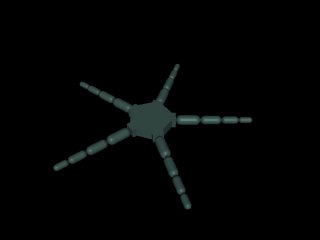

In [6]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

We can also specify a different amount of segments per arm.

""

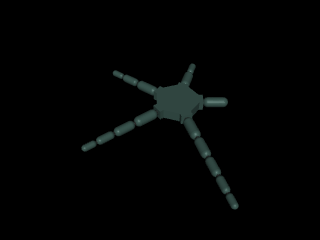

In [7]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=[1, 2, 3, 4, 5], use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

### 2. Creating the arena
Similarly to the morphology, the next step is to configure and create the AquariumArena in which we will put our brittle star. This arena uses a [simplified fluid model](https://mujoco.readthedocs.io/en/stable/computation/fluid.html#inertia-model) to simulate an aquatic environment.

In [8]:
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena


def create_arena(
        arena_configuration: AquariumArenaConfiguration
        ) -> MJCFAquariumArena:
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    return arena

""

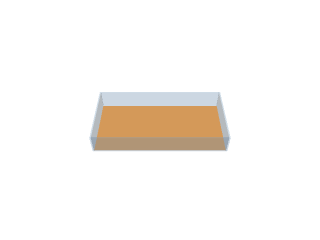

In [9]:
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
arena = create_arena(arena_configuration=arena_configuration)
visualize_mjcf(mjcf=arena)

### 3. Creating the environment
Now we can create the actual environment that combines the above morphology and arena. As discussed above, we have three different environment versions (each specifying a specific task) in which we can put our brittle star. Each version has a specific EnvironmentConfiguration.

In [10]:
from brb.brittle_star.environment.light_escape.shared import BrittleStarLightEscapeEnvironmentConfiguration
from brb.brittle_star.environment.directed_locomotion.shared import \
    BrittleStarDirectedLocomotionEnvironmentConfiguration
from brb.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration

locomotion_environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        # If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities 
        joint_randomization_noise_scale=0.0, render_mode="rgb_array",  # Visualization mode 
        simulation_time=5,  # Number of seconds per episode 
        num_physics_steps_per_control_step=10,  # Number of physics substeps to do per control step 
        time_scale=2,    # Integer factor by which to multiply the original physics timestep of 0.002,
        camera_ids=[0, 1],   # Which camera's to render (all the brittle star environments contain 2 cameras: 1 top-down camera and one close-up camera that follows the brittle star),
        render_size=(480, 640)  # Resolution to render with ((height, width) in pixels)
        )
target_locomotion_environment_configuration = BrittleStarDirectedLocomotionEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )
light_escape_environment_configuration = BrittleStarLightEscapeEnvironmentConfiguration(
        # If this value is > 0, we will add perlin noise to the generated light map. Otherwise, the light map is a simple linear gradient.
        #   Please only provide integer factors of 200.
        light_perlin_noise_scale=0,
        joint_randomization_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

The [environment configuration's superclass](https://github.com/Co-Evolve/mujoco-utils/blob/main/mujoco_utils/environment.py#L39) also contains some helpful utility functions. 

Note: we define a 'physics step' as one in which the physics is advanced, and we define a 'control step' as one in which we pass novel actions to the environment. One 'control step' can thus induce one or multiple underlying 'physics steps', and this is what the `num_physics_steps_per_control_step` parameter defines.

In [11]:
print(f"[simulation_time] The total amount of time (in seconds) that one simulation episode takes: {locomotion_environment_configuration.simulation_time}")
print(f"[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: {locomotion_environment_configuration.physics_timestep}")
print(f"[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: {locomotion_environment_configuration.control_timestep}")
print(f"[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: {locomotion_environment_configuration.total_num_physics_steps}")
print(f"[total_num_control_steps] The total amount of control steps that happen during one simulation episode: {locomotion_environment_configuration.total_num_control_steps}")

[simulation_time] The total amount of time (in seconds) that one simulation episode takes: 5
[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: 0.004
[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: 0.04
[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: 1250
[total_num_control_steps] The total amount of control steps that happen during one simulation episode: 125


#### Creator
We can now define a function that takes in a certain morphological specification, the arena configuration and the environment configuration and returns the actual environment. Note that we have added an additional argument to this function,`backend`, which can be used to choose between instantiating the MJC (native MuJoCo) or the MJX (JAX-based MuJoCo) implementation of the environment.

In [12]:
from brb.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from brb.brittle_star.environment.directed_locomotion.dual import BrittleStarDirectedLocomotionEnvironment
from brb.brittle_star.environment.light_escape.dual import BrittleStarLightEscapeEnvironment
from mujoco_utils.environment.dual import DualMuJoCoEnvironment
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration


def create_environment(
        morphology_specification: BrittleStarMorphologySpecification,
        arena_configuration: AquariumArenaConfiguration,
        environment_configuration: MuJoCoEnvironmentConfiguration,
        backend: str
        ) -> DualMuJoCoEnvironment:
    assert backend in ["MJC", "MJX"], "Please specify a valid backend; Either 'MJC' or 'MJX'"

    morphology = create_morphology(
            morphology_specification=morphology_specification
            )
    arena = create_arena(
            arena_configuration=arena_configuration
            )
    if isinstance(environment_configuration, BrittleStarUndirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarUndirectedLocomotionEnvironment
    elif isinstance(environment_configuration, BrittleStarDirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarDirectedLocomotionEnvironment
    else:
        env_class = BrittleStarLightEscapeEnvironment

    env = env_class.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend=backend
            )
    return env

Given the above utility functions, the next code snippet instantiates the environment and renders a single frame. 
Use this to test the influence of different parameters and configurations.

""

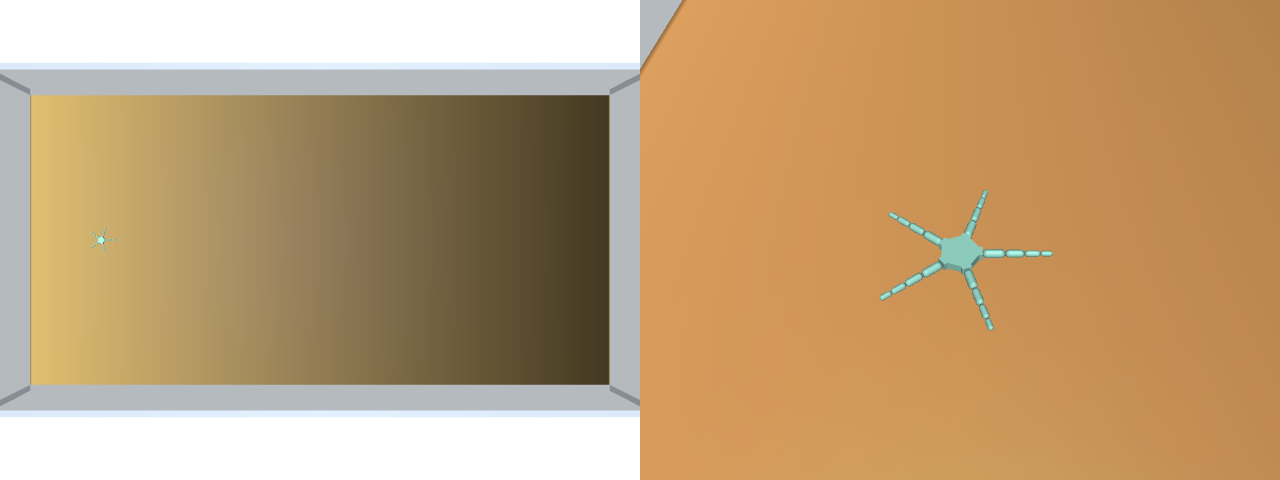

In [13]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarLightEscapeEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        light_perlin_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

BACKEND = "MJC"

env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend=BACKEND
        )

if BACKEND == "MJC":
    rng = np.random.RandomState(0)
else:
    rng = jax.random.PRNGKey(seed=0)

state = env.reset(rng=rng)  # Always need to reset the environment before doing anything else with it
frame = env.render(state=state)
media.show_image(post_render(render_output=frame, environment_configuration=environment_configuration))
env.close()  # always close the environment after using it!

## Using the environment
In this section we will check how we can now actually use the environments. Let's start by instantiating both an MJC and MJX variant.

In [14]:
mjc_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJC"
        )
mjx_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

### Observation space
The observation describes the dimensionality and range of the observations that the environment returns upon reset and after taking a step. As both the MJC and MJX variants implement the same environment, although with a different backend, they have the same observation space (order in which different observations are printed might be a bit different though).

In [15]:
print("MJC:")
print(f"\t{mjc_env.observation_space}")
print("MJX:")
print(f"\t{mjx_env.observation_space}")

MJC:
	Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'joint_actuator_force': Box(-inf, inf, (40,), float32), 'joint_position': Box(-0.5235988, 0.5235988, (40,), float32), 'joint_velocity': Box(-inf, inf, (40,), float32), 'segment_contact': Box(0.0, 1.0, (20,), float32), 'segment_light_intake': Box(0.0, 1.0, (20,), float32))
MJX:
	Dict('joint_position': Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (40,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (

### Action space
The action space describes the dimensionality and range of actions the environment expects in order to take a step. In essence, the environment maps each given action to the control signal of an actuator. Each joint is given an actuator that can control the joints position (either directly through position actuators or indirectly through torque actuators). For the in-plane joints, a positive actuator signal means that the segment will point leftwards (when looking at the segment from the central disc), and rightwards for a negative actuator signal. For the out-of-plane joints, a positive actuator signal means that the segment will point upwards and downwards for a negative actuator signal. 

In [16]:
print("MJC:")
print(f"\t{mjc_env.action_space}")
print("MJX:")
print(f"\t{mjx_env.action_space}")

MJC:
	Box(-0.5235988, 0.5235988, (40,), float32)
MJX:
	Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>)


To help in knowing which action is mapped to which actuator, the following call returns a list of actuator names such that `actions[i]` is mapped to `actuator[i]`. This order is always the same between MJC and MJX.

In [17]:
print("First 5 actuators:")
print(f"\tMJC: {mjc_env.actuators[:5]}")
print(f"\tMJX: {mjx_env.actuators[:5]}")

First 5 actuators:
	MJC: ['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_in_plane_joint_p_control']
	MJX: ['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_2_in_plane_joint_p_control']


### Running and visualizing an episode
Now we will run the simulation environment and visualize it. As shown below, this happens in a similar manner for both the MJC and the MJX variants, as both follow the interface defined in [mujoco-utils](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/base.py#L109). This interface follows the functional programming paradigm. Put simply, this means that we rely only on pure functions (i.e. functions that are deterministic and without side effects). Consequently, when interacting with the environment, we will always have an explicit environment state that is passed around (instead of relying on the environment to adapt its state). The main difference between the MJC and MJX variants is that the MJC variant uses [MJCEnvState](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/mjc_env.py#L24) (which contains Numpy arrays and Numpy's random states), while the MJX variant uses [MJXEnvState](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/mjx_env.py#L54) (which contains JAX arrays and JAX's random number generators).

The most important variables stored in the environment state are:
- `observations`: a dictionary mapping an observation's identifier to its values
- `terminated`: boolean value that denotes whether the episode is terminated (e.g. because the goal was reached)
- `truncated`: boolean value that denotes whether the episode was truncated (e.g. because the time limit was reached)
- `reward`: float value that denotes the reward of doing the given actions in the previous state
- `info`: a dictionary that the environment can use to pass additional information to the user
- `rng`: the current random number generator's state

Note1: Always reset the environment when the current episode has been terminated or truncated.
Note2: When rendering the environment, you might want to increase the resolution to increase visibility (rendering will be slower then though). This can be done through the [environment configuration](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/base.py#L29)'s `render_size` attribute, which denotes the `(height, width)` in pixels.

#### MJC

In [18]:
mjc_env_rng = np.random.RandomState(seed=0)

mjc_state = mjc_env.reset(rng=mjc_env_rng)

mjc_frames = []
while not (mjc_state.terminated | mjc_state.truncated):
    action = mjc_env.action_space.sample()
    mjc_state = mjc_env.step(state=mjc_state, action=action)
    mjc_frames.append(post_render(mjc_env.render(state=mjc_state), mjc_env.environment_configuration))
show_video(images=mjc_frames)

#### MJX
The first time that you run this cell will take a while because of the JIT-compilation. Subsequent calls will however go faster.
Note: As discussed further below, MJX always runs much slower than MJC when running only a single environment (even after jitting) and especially when rendering every step! MJX only shines when we're running many environments simultaneously and skip the rendering.

In [19]:
rng = jax.random.PRNGKey(seed=0)
mjx_env_rng, action_rng = jax.random.split(rng, 2)

jit_step = jax.jit(mjx_env.step)
jit_reset = jax.jit(mjx_env.reset)

mjx_state = jit_reset(rng=mjx_env_rng)

mjx_frames = []
while not (mjx_state.terminated | mjx_state.truncated):
    action_rng, sub_rng = jax.random.split(action_rng, 2)
    action = mjx_env.action_space.sample(rng=sub_rng)

    mjx_state = jit_step(state=mjx_state, action=action)
    mjx_frames.append(post_render(mjx_env.render(state=mjx_state), mjx_env.environment_configuration))
show_video(images=mjx_frames)

Avoid memory leaks and always close your environment after using!

In [21]:
mjc_env.close()
mjx_env.close()

AttributeError: 'BrittleStarLightEscapeMJCEnvironment' object has no attribute '_mj_model'

### Vectorization
During optimization we often want multiple environments to run in parallel as this increases data collection speed. For instance with evolutionary optimization, this allows to evaluate multiple candidate solutions in parallel. Alternatively in the reinforcement learning setting, this can be used to simultaneously collect data from slightly different environment versions if we use randomization or noise.

#### MJC
MJC runs on the CPU, so when we want to run multiple instances of the environment in parallel, we can choose between multithreading and multiprocessing. In this case, we'll go for multiprocessing and use mujoco-utils' [ThreadedVectorMJCEnvWrapper](https://github.com/Co-Evolve/mujoco-utils/blob/new-framework/mujoco_utils/environment/mjc_env.py#L222). Given [Python's Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock), the environment's python code will thus not run truly in parallel; the underlying calls to the MuJoCo physics engine however will. When vectorizing over the CPU, we often use one environment instance for CPU core available.

In [21]:
from mujoco_utils.environment.mjc_env import ThreadedVectorMJCEnvWrapper

NUM_MJC_ENVIRONMENTS = 2  # set this to the number of CPU cores that you have available 

mjc_vectorized_env = ThreadedVectorMJCEnvWrapper(
        lambda: create_environment(
                morphology_specification=morphology_specification,
                arena_configuration=arena_configuration,
                environment_configuration=environment_configuration,
                backend="MJC"
                ), num_environments=NUM_MJC_ENVIRONMENTS
        )

mjc_vectorized_env_rng = [np.random.RandomState(seed=i) for i in range(NUM_MJC_ENVIRONMENTS)]

mjc_vectorized_state = mjc_vectorized_env.reset(rng=mjc_vectorized_env_rng)

mjc_frames = []
while not np.any(mjc_vectorized_state.terminated | mjc_vectorized_state.truncated):
    action = mjc_vectorized_env.action_space.sample()
    mjc_vectorized_state = mjc_vectorized_env.step(state=mjc_vectorized_state, action=action)
    mjc_frames.append(
            post_render(
                mjc_vectorized_env.render(state=mjc_vectorized_state),
                mjc_vectorized_env.environment_configuration
                )
            )
show_video(images=mjc_frames)

As illustrated below by the adapted `observation_space` and `action_space`, our environment will now return a batched version of the original observations, and expect a batched version of the original actions. Each sample in these batches corresponds to the observations and actions of a single underlying environment.

In [22]:
print("Observation space:")
print(f"\t{mjc_vectorized_env.observation_space}")
print("Action space:")
print(f"\t{mjc_vectorized_env.action_space}")

Observation space:
	Dict('disk_angular_velocity': Box(-inf, inf, (2, 3), float32), 'disk_linear_velocity': Box(-inf, inf, (2, 3), float32), 'disk_position': Box(-inf, inf, (2, 3), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (2, 3), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'in_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (2, 20), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (2, 20), float32), 'segment_contact': Box(0.0, 1.0, (2, 20), float32), 'segment_light_intake': Box(0.0, 1.0, (2, 20), float32))
Action space:
	Box(-0.5235988, 0.5235988, (2, 40), float32)


#### MJX

The MJX environment can also be vectorized on the CPU, but it's main performance advantage comes from parallelization on the GPU (which JAX enables). MJX basically implements environment / physics steps as operator over big Jax arrays (e.g. an array of all current joint positions, one with all current joint velocities, ...). To parallelize, it just adds an additional batch dimension over these arrays via [jax.vmap](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html). When vectorizing over the GPU, we often run one environment instance per CUDA core available (this can be found on your GPU's datasheet). The cool thing is that a single GPU has a lot more of these cores than the number of CPU cores your computer (or even a regular cluster) has. 

As a rule-of-thumb:
- Use MJC when you want to run a single environment (e.g. to do a quick test or to visualize a single rollout).
- Use MJX when you (1) have a GPU available, and (2) are doing an optimization.
- Read: https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits

Note: Rendering MJX environments requires the JAX datastructures (on the GPU) to be loaded back into the original MuJoCo structures (on the CPU). This datatransfer has a severe impact; So never render when collecting data during an optimization! (This rule also counts for MJC environments: rendering slows down everything, so only do it when necessary!)

In [ ]:
NUM_MJX_ENVIRONMENTS = 2  # set this to the number of CUDA cores that you have available

mjx_vectorized_env = create_environment(
                morphology_specification=morphology_specification,
                arena_configuration=arena_configuration,
                environment_configuration=environment_configuration,
                backend="MJX"
                )

mjx_action_rng, mjx_vectorized_env_rng = jax.random.split(jax.random.PRNGKey(0), 2)
mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS))

mjx_vectorized_step = jax.jit(jax.vmap(mjx_vectorized_env.step))
mjx_vectorized_reset = jax.jit(jax.vmap(mjx_vectorized_env.reset))
mjx_vectorized_action_sample = jax.jit(jax.vmap(mjx_vectorized_env.action_space.sample))

In [ ]:
mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

mjx_frames = []
while not jnp.any(mjx_vectorized_state.terminated | mjx_vectorized_state.truncated):
    mjx_action_rng, *sub_rngs = jnp.array(jax.random.split(mjx_action_rng, NUM_MJX_ENVIRONMENTS + 1))
    action = mjx_vectorized_action_sample(rng=jnp.array(sub_rngs))
    
    mjx_vectorized_state = mjx_vectorized_step(state=mjx_vectorized_state, action=action)
    mjx_frames.append(
            post_render(
                mjx_vectorized_env.render(state=mjx_vectorized_state),
                mjx_vectorized_env.environment_configuration
                )
            )
show_video(images=mjx_frames)

In [25]:
print("Observation space:")
print(f"\t{mjx_vectorized_env.observation_space}")
print("Action space:")
print(f"\t{mjx_vectorized_env.action_space}")

Observation space:
	Dict('in_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>), 'in_plane_joint_velocity': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_velocity': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'segment_light_intake': Box(0.0, 1.0, (20,), <class 'jax.numpy.float32'>))
Action space:
	Box(-0.5235988, 0.5235988, (40,), <class 'jax.numpy.float32'>)


In [26]:
mjc_vectorized_env.close()
mjx_vectorized_env.close()

## Exercise
Play around with the different brittle star environments. Take a closer look at the different observations, try to do a speed comparison between MJC and MJX environments, ...